In [7]:
import os

import sqlite3
import pandas as pd
import numpy
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, cm

In [8]:
# Path to the root directory of datasci
dthon_path = os.path.join(os.path.expanduser('~'), 'Projects','datasci')
dthon_db = os.path.join(dthon_path, "melbourne-datathon","data","medi.db")

In [18]:
def build_map():
    minlat = -45;
    maxlat = -10;
    minlon = 110;
    maxlon = 155;
    # Vic
    minlat = -40;
    maxlat = -35;
    minlon = 138;
    maxlon = 150;

    m = Basemap(
      projection='merc',
      llcrnrlat=minlat,
      urcrnrlat=maxlat,
      llcrnrlon=minlon,
      urcrnrlon=maxlon,
      lat_ts=20,
      resolution='f'
    )

    m.drawcoastlines()
    m.drawmapboundary()
    m.drawstates()
    
    return m;
    

In [10]:
def gen_coords(m, df):
    
    # Generate co-ordinates array
    xi = []
    yi = []

    for name, rows in df.iterrows():
        xi.append(rows["lon"])
        yi.append(rows["lat"])

    x, y = m(xi, yi)
    
    return {'x': x, 'y':y}
    

In [11]:
# grabs no. of random patients defined by LIMIT below and can be handled by my memory
def bulk_patient_illness_ltd(num, illness, conn):
    sql = """
        SELECT
            t2.Patient_ID,
            t2.'Store_ID',
            t2.'Prescriber_ID',
            t2.'Drug_ID',
            t2.'Prescription_Week',
            t2.'Dispense_Week',
            t2.'Drug_Code',
            t2.'NHS_Code',
            t2.'PatientPrice_Amt', 
            t2.'WholeSalePrice_Amt',
            t2.'GovernmentReclaim_Amt', 
            t2.'StreamlinedApproval_Code', 
            -- t2.'ChemistListPrice',
            p.year_of_birth,
            p.postcode,
            p.gender,
            pc.latitude as lat,
            pc.longitude as lon,
            EXISTS(
                SELECT 1
                WHERE t2.Drug_ID IN (
                    SELECT c2.MasterProductID
                    FROM ChronicIllness_LookUp c2
                    WHERE c2.ChronicIllness = '{1}'
                )
            ) AS is_{1}_medication

        FROM TRANSACTIONS t2
        JOIN patients p ON t2.Patient_ID = p.Patient_ID
        join postcodes_geo pc on p.postcode = pc.postcode
        WHERE t2.Patient_ID IN (
            SELECT ic.Patient_ID FROM implied_condition ic
            WHERE ic.ChronicIllness = '{1}'
            GROUP BY ic.Patient_ID -- Yeilds all patients that have ever taken db medi
            ORDER BY RANDOM()
            LIMIT {0} -- grab only this many random people
        )
        GROUP BY t2.Patient_ID;
    """.format(num, illness)

    return pd.read_sql_query(sql, conn)

In [12]:
# grabs no. of random patients defined by LIMIT below and can be handled by my memory
def bulk_patient_illness(illness, conn):
    sql = """
        SELECT
            t2.Patient_ID,
            t2.'Store_ID',
            p.year_of_birth,
            p.postcode,
            p.gender,
            pc.latitude as lat,
            pc.longitude as lon
        FROM TRANSACTIONS t2
        JOIN patients p ON t2.Patient_ID = p.Patient_ID
        join postcodes_geo pc on p.postcode = pc.postcode
        WHERE t2.Patient_ID IN (
            SELECT ic.Patient_ID FROM implied_condition ic
            WHERE ic.ChronicIllness = '{0}'
            GROUP BY ic.Patient_ID -- Yeilds all patients that have ever taken db medi
        )
        GROUP BY t2.Patient_ID;
    """.format(illness)

    return pd.read_sql_query(sql, conn)

In [13]:
# grabs no. of random patients defined by LIMIT below and can be handled by my memory
def bulk_postcode_illness(illness, conn):
    sql = """
        SELECT
            count(t2.Patient_ID) as num_ill,
            p.postcode,
            pc.state,
            pc.latitude as lat,
            pc.longitude as lon
        FROM TRANSACTIONS t2
        JOIN patients p ON t2.Patient_ID = p.Patient_ID
        join postcodes_geo pc on p.postcode = pc.postcode
        WHERE t2.Patient_ID IN (
            SELECT ic.Patient_ID FROM implied_condition ic
            WHERE ic.ChronicIllness = '{0}'
            GROUP BY ic.Patient_ID -- Yeilds all patients that have ever taken disease related medi
        )
        GROUP BY p.postcode
        ORDER BY num_ill desc;
    """.format(illness)

    return pd.read_sql_query(sql, conn)

In [14]:
conn = sqlite3.connect(dthon_db)

#%time df = bulk_patient_illness('Epilepsy', conn)

In [15]:
%time df = bulk_postcode_illness('Epilepsy', conn)

CPU times: user 46.9 s, sys: 1.95 s, total: 48.9 s
Wall time: 1min


In [69]:
%time dfht = bulk_postcode_illness('Hypertension', conn)

CPU times: user 2min 8s, sys: 4.88 s, total: 2min 13s
Wall time: 2min 33s


In [70]:
dfht.head()

,num_ill,postcode,state,lat,lon
0,276090,2650,NSW,-35.16,147.51
1,240084,4350,QLD,-27.62,151.77
2,233076,2620,NSW,-35.58,149.23
3,199049,4670,QLD,-24.84,152.02
4,194948,7250,TAS,-41.46,147.08


In [71]:
dfht['num_ill'].iloc[0]

276090

In [86]:
plt.figure(figsize=(16,16))
m = build_map()
c = gen_coords(m, df)

# Depression
m.scatter(c['x'], c['y'], 1,marker='o',color='red')

# 
#plt.show()

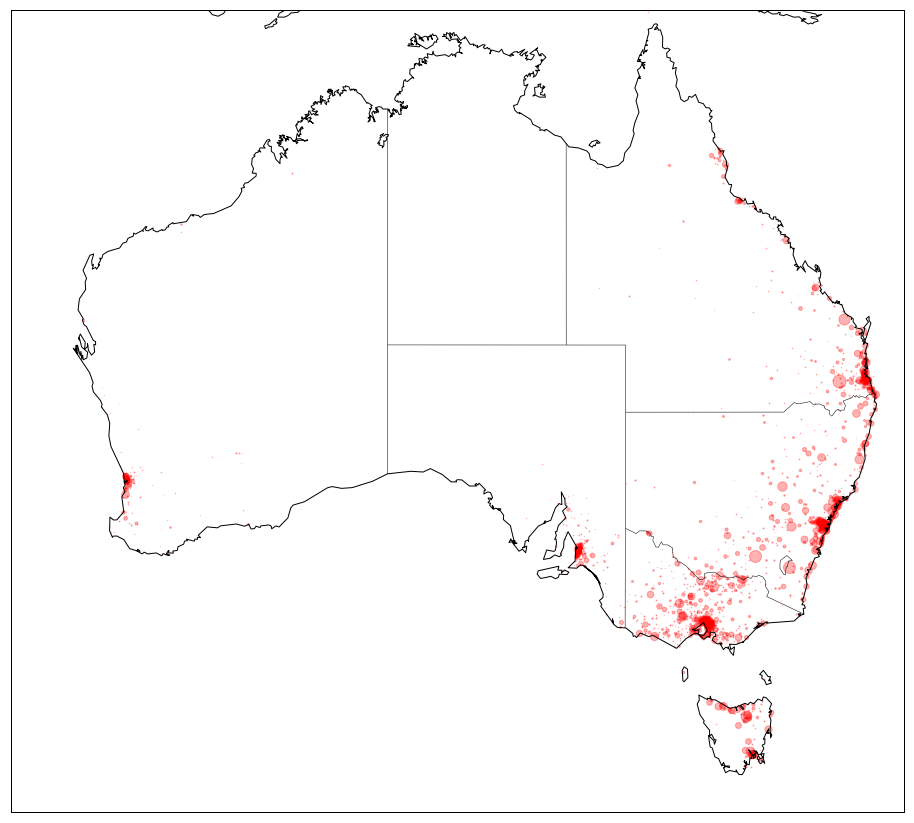

In [84]:
plt.figure(figsize=(16,16))
m = build_map()
#c = gen_coords(m, dfht)

lrg = float(dfht['num_ill'].iloc[0])

# Hypertension
# Generate co-ordinates array
for name, rows in df.iterrows():
    xi = []
    yi = []
    
    size = (float(rows['num_ill']) / lrg) * 400
    
    xi.append(rows["lon"])
    yi.append(rows["lat"])

    x, y = m(xi, yi)
    plt.scatter(x, y, alpha=0.3, s=size,marker='o',color='red')

plt.show()

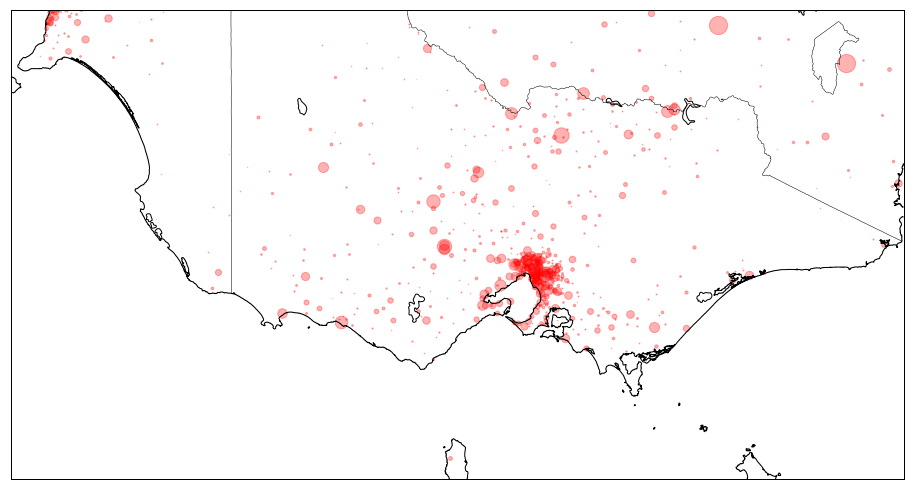

In [19]:
plt.figure(figsize=(16,16))
m = build_map()
#c = gen_coords(m, dfht)

lrg = float(df['num_ill'].iloc[0])

# Epilepsy
# Generate co-ordinates array
for name, rows in df.iterrows():
    xi = []
    yi = []
    
    size = (float(rows['num_ill']) / lrg) * 400
    
    xi.append(rows["lon"])
    yi.append(rows["lat"])

    x, y = m(xi, yi)
    plt.scatter(x, y, alpha=0.3, s=size,marker='o',color='red')

plt.show()

In [76]:
(rows['num_ill'] / lrg) * 200

0

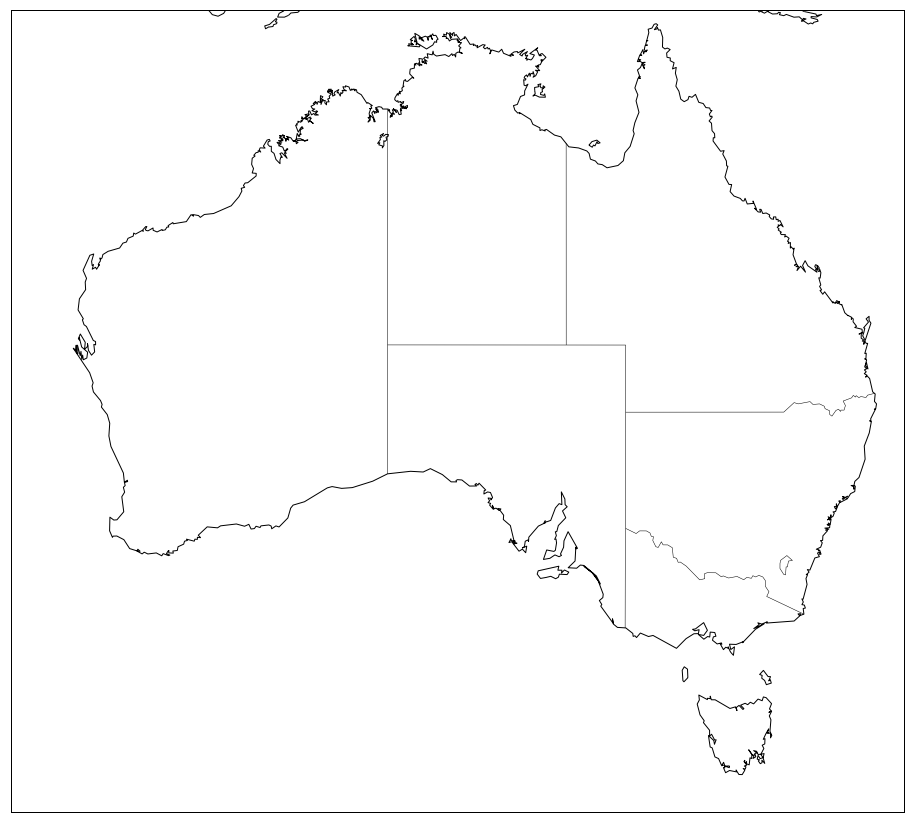

In [46]:
plt.figure(figsize=(16,16))
m = build_map()

plt.show()

In [50]:
# Now doing similar things with panda commands, simplifying SQL
# Same result == good

# In summary, acheived a little, but have had to resort to casting
# floats as floats and sql if I want to do anything like sum or mean below??
sql = """select s.postcode, t.PatientPrice_Amt, t.WholeSalePrice_Amt
        from transactions t
        join stores s on t.Store_ID = s.Store_ID
        where t.Drug_ID = 3028
        --and s.postcode >= 3000
        --and s.postcode < 3500
        and t.PatientPrice_Amt > 0
        """

dfs = pd.read_sql(sql, conn)

In [51]:
dfs.describe()

,postcode,PatientPrice_Amt,WholeSalePrice_Amt
count,10263,10263.0,10263.00
unique,531,391.0,56.00
top,7011,6.0,1.86
freq,309,1584.0,3177.00


In [87]:
aggregations = {
    'PatientPrice_Amt': {
        'Min Patient Price': 'min',
        'Max Patient Price': 'max'
    },
    'WholeSalePrice_Amt': {
        'Avg Patient Price': 'mean',
        'Max Patient Price': 'max'
    }
}

dfs.groupby('postcode').agg(aggregations)



PatientPrice_Amt                   WholeSalePrice_Amt  \
         Min Patient Price Max Patient Price  Max Patient Price   
postcode                                                          
0812                  4.75              4.75               1.12   
0820                  5.80               5.8               1.86   
2000                  5.60                16               2.70   
2006                 10.35             10.35               2.70   
2007                  7.00                 7               2.70   
2011                 14.65             14.65               2.70   
2018                  5.60               5.6               1.86   
2020                  1.96               6.2               4.66   
2021                  9.90               9.9               1.86   
2022                  5.60             13.45               4.66   
2027                  6.00                 8               1.86   
2029                  9.75              9.75               1.86   
2031                  5.60               6.1               3.72   
2040                  6.00              9.47               2.70   
2045                  5.60               5.8               1.86   
2046                  5.60                 6               2.70   
2068                  5.60               5.9               1.86   
2076                  5.60               5.9               1.86   
2077                  5.60                 6               8.11   
2084                  6.00             17.85              13.98   
2095                  5.60                 6               2.70   
2099                  9.99              9.99               1.77   
2103                  5.60              6.95               2.70   
2107                  5.60               5.8               1.86   
2112                  2.00                12               5.41   
2113                  5.60               5.9               1.86   
2115                  5.60              14.8               5.41   
2117                  5.60               6.1               2.70   
2118                  5.60             15.45               5.41   
2120                  1.96             14.35               5.41   
...                    ...               ...                ...   
6026                  5.60             17.85               1.86   
6027                  7.15             15.25               3.58   
6056                 19.95             20.95               2.70   
6057                 17.05             17.05               5.41   
6060                  6.10               6.1               5.41   
6076                  5.60              16.7               2.70   
6150                 21.20              21.2               8.11   
6154                 21.20              21.4               5.41   
6157                  5.60              24.4              10.82   
6162                 15.95                18               5.58   
6164                  5.60               5.6               1.86   
6173                  5.90               6.1               5.41   
6210                 13.58             15.98               5.41   
6230                  5.60               5.6               5.41   
6430                  5.90               6.1               5.41   
6450                 15.95             15.95               2.70   
6701                 16.95             16.95               2.70   
7000                  5.60               5.6               3.72   
7011                  1.96              8.26               4.66   
7018                  6.00                 6               6.49   
7140                  5.90               6.1               5.41   
7190                  5.60              13.6               5.41   
7216                  5.80               5.8               3.72   
7248                  6.10               6.1               5.41   
7249                  5.60             10.11               9.32   
7250                  5.60             15.69             

In [206]:
patient_id = [1,4]

SQL = """
SELECT *
FROM transactions a
LEFT OUTER JOIN ChronicIllness_LookUp b
ON a.Drug_ID = b.MasterProductID
LEFT OUTER JOIN patients c
ON a.Patient_ID = c.Patient_ID
WHERE a.Patient_ID = {}
   """.format(patient_id)

pd.read_sql_query(SQL, conn)

DatabaseError: Execution failed on sql '
SELECT *
FROM transactions a
LEFT OUTER JOIN ChronicIllness_LookUp b
ON a.Drug_ID = b.MasterProductID
LEFT OUTER JOIN patients c
ON a.Patient_ID = c.Patient_ID
WHERE a.Patient_ID = [1, 4]
   ': no such column: 1, 4